In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize

(512, 512, 3)


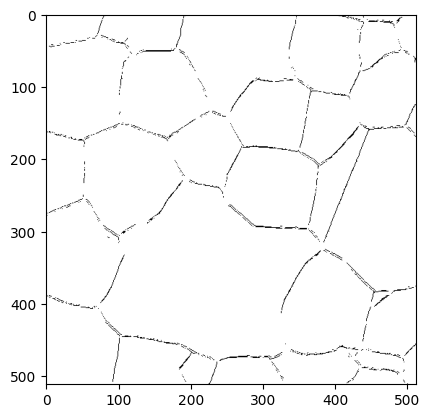

In [2]:
img = cv2.imread('output_mask.png', cv2.IMREAD_COLOR)
print(img.shape)
plt.imshow(img)

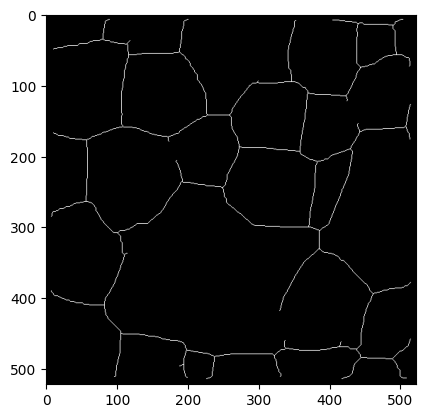

In [3]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, binary_img = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY_INV)
pad_img = np.pad(binary_img, pad_width=((5,5),(5,5)), mode='constant', constant_values=0)
kernel = np.ones((3,3), np.uint8)
dilated = cv2.dilate(pad_img, kernel, iterations=10)
closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel=np.ones((5,5), np.uint8), iterations=1)
skeleton = skeletonize(closed // 255).astype(np.uint8) * 255
plt.imshow(skeleton, cmap='gray')

In [4]:
# 끝점을 정확히 찾는 함수
def find_endpoints(skel):
    endpoints = []
    h, w = skel.shape
    for y in range(1, h - 1):
        for x in range(1, w - 1):
            if skel[y, x] == 255:
                neighborhood = skel[y-1:y+2, x-1:x+2]
                if np.sum(neighborhood == 255) == 2:  # 본인 포함 2픽셀(즉 주변 픽셀 1개만 연결된 상태)
                    endpoints.append((y, x))
    return endpoints

# 끝점들을 가장자리와 연결하는 함수
def connect_endpoints_to_edges(skeleton, threshold=50):
    h, w = skeleton.shape
    endpoints = find_endpoints(skeleton)
    connected = skeleton.copy()

    for y, x in endpoints:
        # 각 끝점에서 가장 가까운 가장자리 판단
        distances = {'left': x, 'right': w - x - 1, 'top': y, 'bottom': h - y - 1}
        closest_edge, min_dist = min(distances.items(), key=lambda item: item[1])

        # threshold 내의 가장자리로 연결
        if min_dist < threshold:
            if closest_edge == 'left':
                cv2.line(connected, (x, y), (0, y), 255, 1)
            elif closest_edge == 'right':
                cv2.line(connected, (x, y), (w - 1, y), 255, 1)
            elif closest_edge == 'top':
                cv2.line(connected, (x, y), (x, 0), 255, 1)
            elif closest_edge == 'bottom':
                cv2.line(connected, (x, y), (x, h - 1), 255, 1)

    return connected

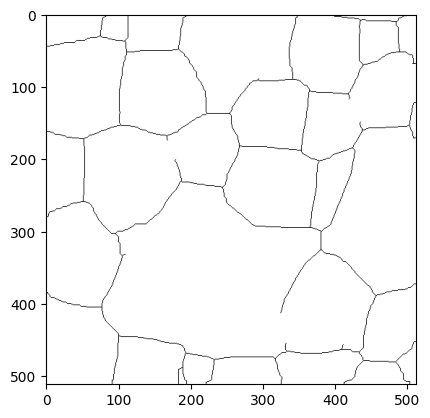

In [7]:
connected = connect_endpoints_to_edges(skeleton, threshold=50)
cropped_back = connected[5:-5, 5:-5]
final_img = np.ones_like(cropped_back, dtype=np.uint8) * 255
final_img[cropped_back == 255] = 0
plt.imshow(final_img, cmap='gray')

In [8]:
final_img.shape

(512, 512)

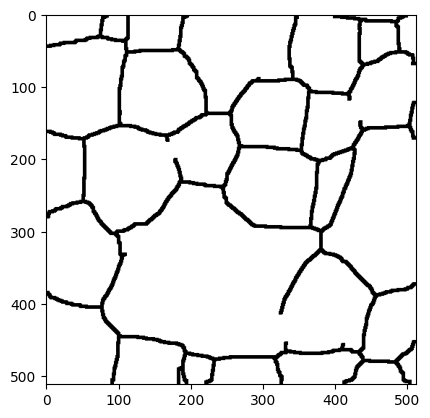

In [14]:
kernel = np.ones((3, 3), np.uint8)
eroded_image = cv2.erode(final_img, kernel, iterations=2)
plt.imshow(eroded_image, cmap='gray')

In [15]:
contours, _ = cv2.findContours(eroded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
areas = [cv2.contourArea(contour) for contour in contours]
areas

[26.5,
 1606.5,
 2846.5,
 1150.0,
 4040.0,
 653.5,
 4885.0,
 9566.5,
 5478.0,
 10954.5,
 58113.0,
 3112.0,
 10830.0,
 4533.0,
 20628.5,
 20192.0,
 112.0,
 7660.5,
 12172.5,
 10292.5,
 12267.0,
 2168.5,
 999.5,
 341.0,
 8425.5,
 14379.0,
 3201.5,
 913.0,
 2529.0]

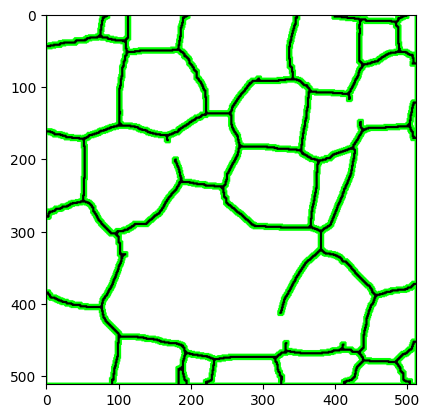

In [16]:
image_color = cv2.cvtColor(eroded_image, cv2.COLOR_GRAY2BGR)
cv2.drawContours(image_color, contours, -1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))